In [13]:
import os
import sys
from pathlib import Path
import json
import re
from collections import Counter

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [5]:
from tqdm.notebook import tqdm

In [6]:
with open("data/misc/arxiv_topics.yaml") as f:
    topics_conf = yaml.safe_load(f)
topic_names = []
for d in topics_conf['topics']:
    topic_names.append(d['name'])
print(f"{topic_names=}")

topic_names=['Computer Science', 'Economics', 'Electrical Engineering and Systems Science', 'Mathematics', 'Physics', 'Quantitative Biology', 'Quantitative Finance', 'Statistics']


In [7]:
sample_assigs = []
with open("data/output/sample/assignment.jsonl", encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            sample_assigs.append(json.loads(line))
sample_assigs[0]

{'id': '111-HR-3692',
 'text': 'National Forest Roadless Area Conservation Act - Identifies roadless areas within the National Forest System set forth in specified maps as National Forest Inventoried Roadless Areas, and directs the Secretary of Agriculture to manage such Areas to maintain their roadless character. Authorizes the Forest Service to modify such maps for the sole purpose of improving their accuracy or inclusiveness. Requires any substantial modification of those maps to be made through the national forest management planning process and documented in an environmental impact statement.',
 'label': 'Public Lands',
 'prompted_docs': 'National Forest Roadless Area Conservation Act - Identifies roadless areas within the National Forest System set forth in specified maps as National Forest Inventoried Roadless Areas, and directs the Secretary of Agriculture to manage such Areas to maintain their roadless character. Authorizes the Forest Service to modify such maps for the sole p

In [8]:
assig_outputs_all = {
    'vlm_firstpage': {
        'path': "output/topic_assignments/vlm_firstpage/all_results.json",
    },
    'vlm_randpage': {
        'path': "output/topic_assignments/vlm_randpage/all_results.json",
    },
    'vlm_randpage2': {
        'path': "output/topic_assignments/vlm_2randompage/all_results.json",
    },
    
    'llm_firstpage': {
        'path': "output/topic_assignments/llm_firstpage/all_results.json",
    },
    'llm_randpage': {
        'path': "output/topic_assignments/llm_randompage/all_results.json",
    },
    'llm_randpage2': {
        'path': "output/topic_assignments/llm_2randompage/all_results.json",
    },
}

In [9]:
def identify_matched_topics_from_response(response: str, topic_names: list):
    if "Final Answer" in response:
        response = response[response.index("Final Answer")+len("Final Answer"):]
    output_pattern = r"\[(?:\d+)\] ([^:]+): (?:.+)"
    output_topics = re.findall(output_pattern, response)
    output_topics = [t for t in output_topics if t in topic_names]
    if len(output_topics) == 0:
        found_topics = []
        for topic_name in topic_names:
            if topic_name in response:
                found_topics.append((response.index(topic_name), topic_name))
        for _, topic_name in sorted(found_topics):
            output_topics.append(topic_name)
    return output_topics

In [ ]:
assig_json_path = assig_outputs_all['vlm_firstpage']['path']
with open(assig_json_path, encoding='utf-8') as f:
    assig_datas = json.load(f)

true_topics_all = []
for i, d in enumerate(tqdm(assig_datas)):
    true_topics = json.loads(d['topics'])
    pred_topics = identify_matched_topics_from_response(d['response'], topic_names=topic_names) #d['matched_topics']
    true_topics = sorted(set(true_topics))
    pred_topics = sorted(set(pred_topics))
    true_topics_all.extend(true_topics)
    if i < 2:
        print(f"True: {true_topics}")
        print(f"Pred: {pred_topics}")
        print(f"LLM response: {d['response']}")

([<matplotlib.patches.Wedge at 0x15543bc79a10>,
 [Text(-0.7165097133490093, 0.834633950110179, 'Mathematics'),
  Text(-0.46007668745945446, -0.9991643716908323, 'Physics'),
  Text(1.096755581148524, 0.08442271743768925, 'Computer Science'),
  Text(0.5649828854197451, 0.943819018235371, 'Statistics'),
  Text(0.3769730720263265, 1.0333882634165312, 'Quantitative Biology'),
  Text(0.34641018192816136, 1.0440306441175462, 'Quantitative Finance'),
  Text(0.17545131317525933, 1.0859175091622186, 'Electrical Engineering and Systems Science'),
  Text(0.003596090906322279, 1.0999941218616551, 'Economics')],
 [Text(-0.39082348000855044, 0.45525488187827945, '22.6%'),
  Text(-0.25095092043242967, -0.5449987481949994, '41.1%'),
  Text(0.5982303169901039, 0.046048754966012316, '25.1%'),
  Text(0.3081724829562245, 0.5148103735829296, '5.3%'),
  Text(0.20562167565072353, 0.5636663254999261, '0.7%'),
  Text(0.18895100832445164, 0.5694712604277524, '0.2%'),
  Text(0.09570071627741417, 0.59231864136121,

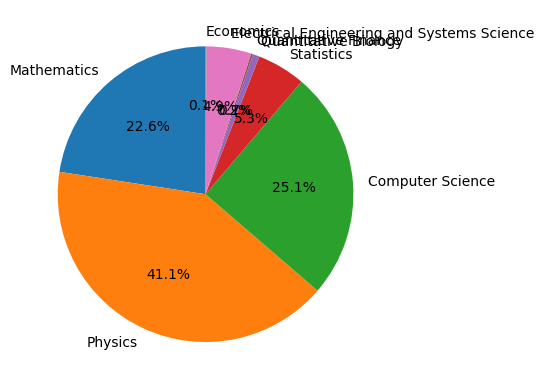

In [15]:
topics_counter = Counter(true_topics_all)
plt.pie(topics_counter.values(),
        labels=topics_counter.keys(), autopct='%1.1f%%', startangle=90)

In [10]:
from topicgpt_python.utils import calculate_metrics

INFO 04-17 17:18:43 [__init__.py:243] No platform detected, vLLM is running on UnspecifiedPlatform


In [12]:
results_allmodels = []

pick1topic_sorted_alphabetically = True
for imodel, (model_name, assig_output_d) in enumerate(assig_outputs_all.items()):
    print("Model {}/{}: {}".format(imodel+1, len(assig_outputs_all), model_name))
    with open(assig_output_d['path'], encoding='utf-8') as f:
        assig_datas = json.load(f)
    curmodel_assig_datas_fordf = []
    for idoc, assig_d in enumerate(tqdm(assig_datas)):
        true_topics = json.loads(assig_d['topics'])
        pred_topics = identify_matched_topics_from_response(assig_d['response'], topic_names=topic_names)
        if pick1topic_sorted_alphabetically:
            true_topics = sorted(set(true_topics))
            pred_topics = sorted(set(pred_topics))
        curmodel_assig_datas_fordf.append({
            'gt': true_topics[0],
            'pred': pred_topics[0] if len(pred_topics) > 0 else "XXXX",
        })
    cur_model_assigdf = pd.DataFrame(curmodel_assig_datas_fordf)
    harmonic_purity, ari, mis = calculate_metrics('gt', 'pred', cur_model_assigdf)
    results_allmodels.append({
        'name': model_name,
        'harmonic_purity': harmonic_purity,
        'ari': ari,
        'mis': mis,
        })
results_allmodels_df = pd.DataFrame(results_allmodels).set_index('name')
results_allmodels_df

Model 1/6: vlm_firstpage


  0%|          | 0/1495 [00:00<?, ?it/s]

Model 2/6: vlm_randpage


/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


  0%|          | 0/1495 [00:00<?, ?it/s]

/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


Model 3/6: vlm_randpage2


  0%|          | 0/1495 [00:00<?, ?it/s]

/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


Model 4/6: llm_firstpage


  0%|          | 0/1495 [00:00<?, ?it/s]

/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


Model 5/6: llm_randpage


  0%|          | 0/1495 [00:00<?, ?it/s]

/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


Model 6/6: llm_randpage2


  0%|          | 0/1495 [00:00<?, ?it/s]

/storage/ice1/4/2/mshin90/hum/topicGPT/topicgpt_python/utils.py:699: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


,harmonic_purity,ari,mis
name,,,
vlm_firstpage,0.473648,0.011540,0.086902
vlm_randpage,0.481143,-0.015996,0.040951
vlm_randpage2,0.475503,0.024531,0.072662
llm_firstpage,0.636141,0.271820,0.324136
llm_randpage,0.517861,0.115412,0.185451
llm_randpage2,0.474751,0.064664,0.123571
